In [158]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import poisson, uniform, norm, cauchy, gaussian_kde

sys.version # check which python interpreter is used  

'3.6.0 (v3.6.0:41df79263a11, Dec 22 2016, 17:23:13) \n[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]'

# Ramp-up Model

Let's model some ramp-ups. :)

We use the option that we only send a part of the traffic to a/b testing during ramp-up, traffic that does not go to a/b testing will by default be the control. After reaching a/b testing, we always make a 50%/50% split of treatment and control.
We simulate in a way that ramp-up happens on day 0 (10% ), day 5 (30%), and day 10 (50%). This is illustrated in the following table.

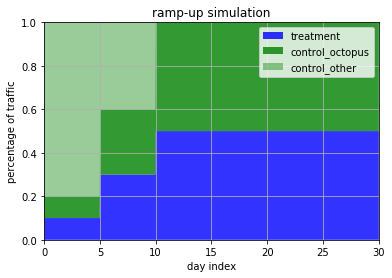

In [159]:
x = np.linspace(0, 30, 1000)
y0 = 0
y1 = [0.1 if i<5 else
      0.3 if i<10 else
      0.5 for i in x]
y2 = [0.2 if i<5 else
      0.6 if i<10 else
      1.0 for i in x]
y3 = 1

fig, ax = plt.subplots()
ax.fill_between(x, y0, y1, facecolor='blue', interpolate=True, alpha=0.8, label="treatment")
ax.fill_between(x, y1, y2, facecolor='green', interpolate=True, alpha=0.8, label="control_octopus")
ax.fill_between(x, y2, y3, facecolor='green', interpolate=True, alpha=0.4, label="control_other")
ax.set_xlim(0, 30)
ax.set_ylim(0, 1)

ax.set_xlabel('day index')
ax.set_ylabel('percentage of traffic')
ax.set_title('ramp-up simulation')
ax.legend()
ax.grid(True)

plt.show()

# Ramp-up Analysis

Here we will compare three approaches of analysis:
* Approach **Straightforward**: Only analyse the period when traffic is split 50/50, don't consider the ramp-up period.
* Approach **Remove ramp-up data**: Analyse the period when traffic is split 50/50 and remove the assignments from the ramp-up period (risk to remove a big part of the assignments).
* Approach **Exposure time**: Consider the whole period (ramp-up + 50/50 split) and use a fixed exposure time (based on actual experiment runtime) for each assignment.

Please refer to epic Ramp-ups: https://techjira.zalando.net/browse/OCTO-1613

# Simulation Data

We generate control and treatment with same normal distribution.

In [160]:
seed = 7
days = 30
total_entities = 10000 
averageVisitPerEntity = 3
base = 0.5
delta = 0
scale = 0.1

def _randomNumberPoisson(lam):
    lower = poisson.pmf(0, lam)
    return poisson.ppf(uniform.rvs(size=1, loc=lower, scale=1 - lower), lam)

def ramp_up_simulation_data():
    np.random.seed(seed)
    assignment = pd.DataFrame({'entity': range(total_entities),
                               'variant': np.random.choice(['A', 'B'], size=total_entities, p=[0.5, 0.5])})
    all_data = pd.DataFrame()
    for e in range(total_entities):
        n_for_e = int(_randomNumberPoisson(averageVisitPerEntity))
        if n_for_e > days:
            n_for_e = days
        timePoints = np.random.choice(days, size=n_for_e, replace=False)
        normal_shifted_rv = norm.rvs(size=n_for_e, loc=base, scale=scale)
        if assignment.variant[assignment.entity == e].iloc[0] == 'B':
            normal_shifted_rv = norm.rvs(size=n_for_e, loc=base+delta, scale=scale)
        df = pd.DataFrame({
            'entity': e,
            'normal_shifted': normal_shifted_rv,
            'time': timePoints
        })
        all_data = all_data.append(df, ignore_index=True)
    all_data = pd.merge(all_data, assignment, on='entity')
    
    for index, row in all_data.iterrows():
        randint = random.randrange(10)
        if row['time'] < 5 and randint < 8:
            all_data.drop(index, inplace=True)
        elif 5 <= row['time'] < 10 and randint < 4:
            all_data.drop(index, inplace=True)
            
    return all_data.reset_index()

In [161]:
data = ramp_up_simulation_data()
data.head()

,index,entity,normal_shifted,time,variant
0,1,0,0.262855,17,A
1,2,0,0.332676,27,A
2,3,0,0.612572,15,A
3,4,0,0.483241,23,A
4,5,1,0.565183,28,B


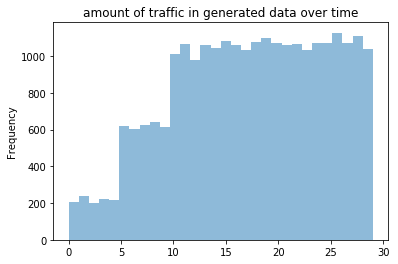

In [162]:
data.time.plot.hist(alpha=0.5, bins=30, title='amount of traffic in generated data over time')
plt.show()

Let's define a utility function that build a dataframe of kpi per variant.

In [163]:
def to_KPI_per_variant(df):
    kpi_A = df[df.variant == "A"]["normal_shifted"]
    kpi_B = df[df.variant == "B"]["normal_shifted"]
    return pd.concat([kpi_A, kpi_B], axis=1, keys=['variant A', 'variant B'])

We can use this utility function to look at the distribution of kpis for the two variants.

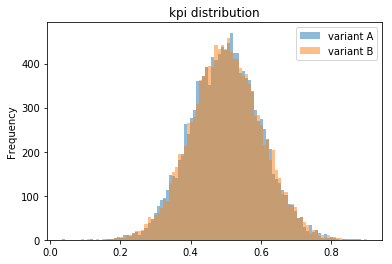

In [164]:
to_KPI_per_variant(data).plot.hist(alpha=0.5, bins=100, title="kpi distribution")
plt.show()

We can see that kpis of the two variant are normally distributed with mean 0.5.

# Effect of Exposure

One propery we want to model is the effect of exposure. If an entity is exposed to treatment for a long period, we might get a decayed kpi value from this enityt because he/she is used to the behaviour. We model this effect by a flipped logistic function, but with a smoother change. Again, we assume the changing point of exposure effect is centered at day 18. 

This effect of exposure is assumed to appear in the treatment gorup. While using a mocked function here, we will also investigate the function of exposure per kpi in real data. 

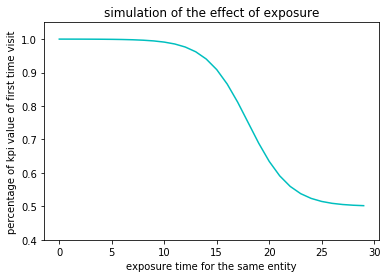

In [165]:
def effect_of_exposure(array_of_days):
    k = 0.5
    return 0.5 / (1 + np.exp(-k*(18-array_of_days))) + 0.5

x = np.arange(30)
y = effect_of_exposure(x)
            
plt.plot(x, y, 'c-')
plt.ylim([0.4, 1.05])
plt.xlabel("exposure time for the same entity")
plt.ylabel("percentage of kpi value of first time visit")
plt.title("simulation of the effect of exposure")
plt.show()

In [166]:
def add_effect_of_exposure(data):
    first_day_per_entity = data.groupby(['entity'])['time'].min().reset_index()
    for i in range(len(data)):
        entity = data.loc[i, 'entity']
        day = data.loc[i, 'time']
        variant = data.loc[i, 'variant']
        if variant == 'B': # only add effect to the treatment
            first_day = first_day_per_entity[first_day_per_entity['entity']==entity].iloc[0, 1]
            time_of_exposure = day - first_day
            percentage_remained = effect_of_exposure(time_of_exposure)
            # print(entity, percentage_remained)
            data.set_value(i, 'normal_shifted', data.loc[i, 'normal_shifted'] * percentage_remained)
    return data

And let's look at how the kpis are distributed now after adding the mocked effect of exposure.

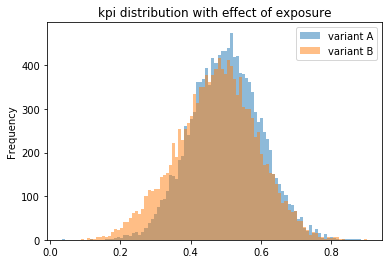

In [167]:
data_with_eoe = add_effect_of_exposure(data)
to_KPI_per_variant(data_with_eoe).plot.hist(alpha=0.5, bins=100, title="kpi distribution with effect of exposure")
plt.show()

Due to effect of exposure, we observed that the distribution of kpi in treatment group has changed. The modal still appears where the original mean were, however, the distribution are wider and skewed toward 0.

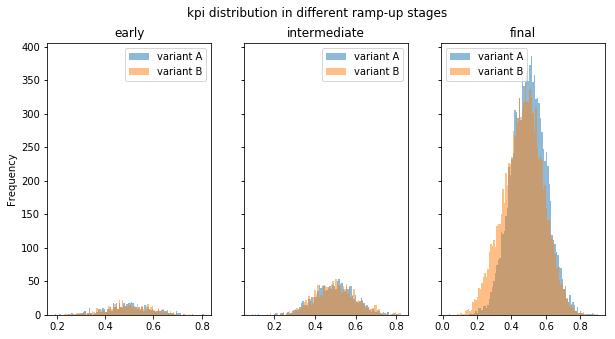

In [168]:
def plot_by_stage(data, title):
    data_with_eoe_grouped_by_stage = data.assign(stage='final')
    for i in range(len(data_with_eoe_grouped_by_stage)):
        day = data_with_eoe_grouped_by_stage.loc[i, 'time']
        if day < 5:
            data_with_eoe_grouped_by_stage.set_value(i, 'stage', 'early')
        elif 5<= day < 10:
            data_with_eoe_grouped_by_stage.set_value(i, 'stage', 'intermediate')

    data_by_stages = [
        (data_with_eoe_grouped_by_stage[data_with_eoe_grouped_by_stage.stage=='early'], 'early'),
        (data_with_eoe_grouped_by_stage[data_with_eoe_grouped_by_stage.stage=='intermediate'], 'intermediate'),
        (data_with_eoe_grouped_by_stage[data_with_eoe_grouped_by_stage.stage=='final'], 'final')
    ]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), sharey=True)
    for data, axis in zip(data_by_stages, axes):
        to_KPI_per_variant(data[0]).plot.hist(alpha=0.5, bins = 100, ax=axis)
        axis.set_title(data[1])
    fig.suptitle(title)
    plt.show()
    return

plot_by_stage(data_with_eoe, "kpi distribution in different ramp-up stages")

The distribution per stage shows that most of the exposure effect happens in the final 50/50 stage, while the effect is not obvious during ramp-up phases.

We will then evaluate the three analysis approaches. First define one method per approach that selects the data for analysis.  

In [169]:
def approach_staightforward(data):
    data_for_analysis = data[data.time>=10].reset_index()
    return data_for_analysis

def approach_remove_rampup_data(data):
    data_for_analysis = data[data.time>=10].reset_index()
    first_day_per_entity = data.groupby(['entity'])['time'].min().reset_index()
    for i in range(len(data_for_analysis)):
        entity = data.loc[i, 'entity']
        variant = data.loc[i, 'variant']
        if variant == "B":
            first_day = first_day_per_entity[first_day_per_entity['entity']==entity].iloc[0, 1]
            if first_day < 10:
                data_for_analysis.drop(i, inplace=True)
    return data_for_analysis

def approach_exposure_time(data):
    return data_for_analysis

We will investigate if the treatment and control group are comparable in early, intermediate and final stages for these approaches.

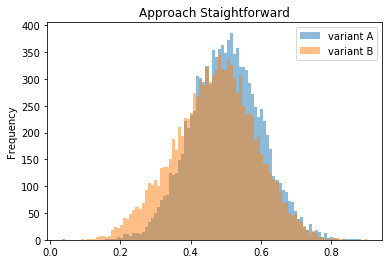

In [170]:
data1 = approach_staightforward(data_with_eoe)
to_KPI_per_variant(data1).plot.hist(alpha=0.5, bins=100, title="Approach Staightforward")
plt.show()

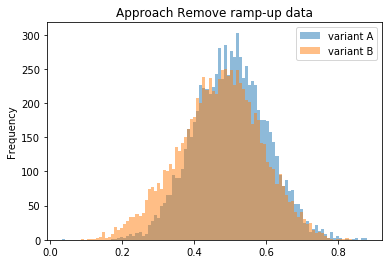

In [171]:
data2 = approach_remove_rampup_data(data_with_eoe)
to_KPI_per_variant(data2).plot.hist(alpha=0.5, bins=100, title="Approach Remove ramp-up data")
plt.show()

# Seasonality Effect

We can also assume that there is mean shift of kpi value over time, in other words, there is a seasonal effect. This is because adding the ramp-up period might make the experiment too long, which leads to the shift of the kpi mean (e.g. run into a sale season). We simulate this behaviour by a sharp logistic function from 0.2 to 0.8, the change is centered at day 10.

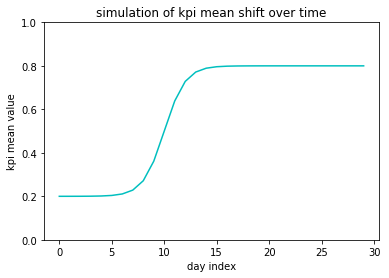

In [172]:
x = np.arange(30)
y = 0.6 / (1 + np.exp(-x+10)) + 0.2
plt.plot(x, y, 'c-')
plt.ylim([0, 1])
plt.xlabel("day index")
plt.ylabel("kpi mean value")
plt.title("simulation of kpi mean shift over time")
plt.show()

In [173]:
add_mean_shift_over_time(data)

NameError: name 'add_mean_shift_over_time' is not defined

# Conclusion

bla

# Q & A

bla